In [ ]:
pip install pandas_ta

In [ ]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import missingno as msno

In [ ]:
amazon_df=pd.read_csv('/content/Amazon_weekly.csv', sep=',', header=0)
amazon_df['Date'] = pd.to_datetime(amazon_df.Date)

In [ ]:
# adjust all past prices for the 2022-06-06 split
amazon_df.loc[amazon_df['Date']<=pd.to_datetime('2022-06-06'),['Open', 'High', 'Low', 'Close']]=amazon_df.loc[amazon_df['Date']<=pd.to_datetime('2022-06-06'),['Open', 'High', 'Low', 'Close']]/20

# adjust problematic section where low is higher than close
amazon_df.loc[amazon_df['Date']<=pd.to_datetime('1999-08-29'),['Open', 'High', 'Low']]=amazon_df.loc[amazon_df['Date']<=pd.to_datetime('1999-08-29'),['Open', 'High', 'Low']]/2
amazon_df.loc[amazon_df['Date']<=pd.to_datetime('1999-01-03'),['Open', 'High', 'Low']]=amazon_df.loc[amazon_df['Date']<=pd.to_datetime('1999-01-03'),['Open', 'High', 'Low']]/3
amazon_df.loc[amazon_df['Date']<=pd.to_datetime('1998-05-31'),['Open', 'High', 'Low']]=amazon_df.loc[amazon_df['Date']<=pd.to_datetime('1998-05-31'),['Open', 'High', 'Low']]/2

# adjust the volume before 2022-06-06 split
amazon_df.loc[amazon_df['Date']<=pd.to_datetime('2022-06-06'),'Volume'] = amazon_df.loc[amazon_df['Date']<=pd.to_datetime('2022-06-06'),'Volume']*20

# assuming volumes were also incorrect for the periods where Open, High and Low were adjusted, we also adjust volumes
amazon_df.loc[amazon_df['Date']<=pd.to_datetime('1999-08-29'),'Volume'] = amazon_df.loc[amazon_df['Date']<=pd.to_datetime('1999-08-29'),'Volume']*2
amazon_df.loc[amazon_df['Date']<=pd.to_datetime('1999-01-03'),'Volume'] = amazon_df.loc[amazon_df['Date']<=pd.to_datetime('1999-01-03'),'Volume']*3
amazon_df.loc[amazon_df['Date']<=pd.to_datetime('1998-05-31'),'Volume'] = amazon_df.loc[amazon_df['Date']<=pd.to_datetime('1998-05-31'),'Volume']*2


from sklearn.preprocessing import StandardScaler, MinMaxScaler

#scaler
scaler = StandardScaler()
scaler2 = MinMaxScaler()
#ATTENZIONE CHE é FATTO CON MINMAX SCALER TUTTO
#standardization of the prices
amazon_df[['Close', 'Open', 'Low', 'High']] = scaler2.fit_transform(amazon_df[['Close', 'Open', 'Low', 'High']])
amazon_df.loc[amazon_df['Volume']>0, ['Volume']] = scaler2.fit_transform(amazon_df.loc[amazon_df['Volume']>0, ['Volume']])

In [ ]:
#hurst coefficient of the time series
def hurst(ts):

    n = len(ts)
    max_window = int(n / 2)
    window_sizes = range(10, max_window)
    R_S = np.zeros(len(window_sizes))

    for i, window_size in enumerate(window_sizes):
        window_ranges = np.arange(0, n, window_size)
        R, S = 0, 0
        for j in window_ranges:
            if j + window_size < n:
                # Calculate the range and standard deviation
                window = ts[j:j+window_size]
                R += np.max(window) - np.min(window)
                S += np.std(window)

        # Calculate the rescaled range
        R_S[i] = R / S

    # Fit a linear line to log-log plot
    fit = np.polyfit(np.log(window_sizes), np.log(R_S), 1)

    # Hurst exponent is the slope of the line
    hurst_exponent = fit[0]

    return hurst_exponent


ts = amazon_df['Close']
print("Hurst Exponent for Close:", hurst(ts))

amazon_df['log return'] = np.log(amazon_df['Close'].shift(-1)/amazon_df['Close'])
ts1 = amazon_df['log return']
print("Hurst Exponent for Log return:", hurst(ts1))

amazon_df['return'] = amazon_df['Close'].shift(-1)/amazon_df['Close']
ts2 = amazon_df['return']
print("Hurst Exponent for return:", hurst(ts2))

Hurst Exponent for Close: 0.02494830588411729


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Hurst Exponent for Log return: nan
Hurst Exponent for return: nan


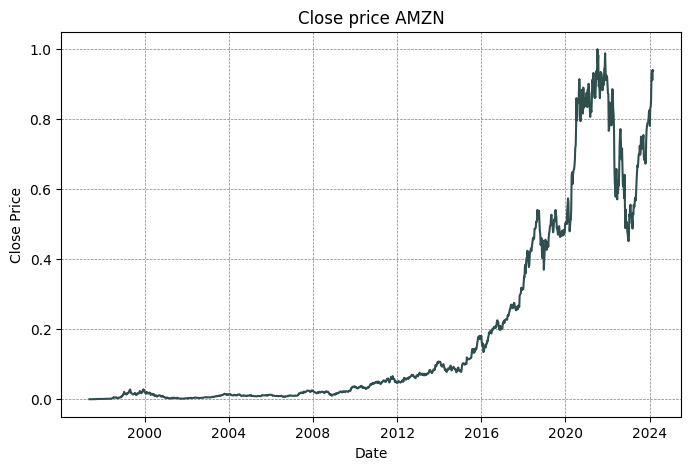

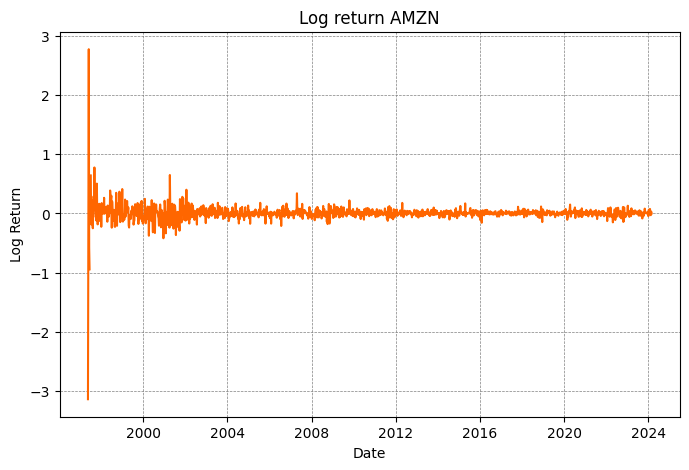

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))
plt.style.use('default')
plt.plot(amazon_df['Date'], amazon_df['Close'], color='#2F4F4F')
ax.grid(True, linestyle='--', linewidth=0.5, color='gray')
plt.title('Close price AMZN')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.gca().set_facecolor('none')
plt.savefig('close AMZN.png', transparent=True)
plt.show()



fig, ax = plt.subplots(figsize=(8, 5))
plt.style.use('default')
plt.plot(amazon_df['Date'], amazon_df['log return'], color='#FF6600')
ax.grid(True, linestyle='--', linewidth=0.5, color='gray')
plt.title('Log return AMZN')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.gca().set_facecolor('none')
plt.savefig('log return AMZN.png', transparent=True)
plt.show()

## PRIMA ARCHITETTURA

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense

def LSTM_model(X_train, p_dropout=0.2):
  model =Sequential()
  model.add(
      LSTM(units=50,
           return_sequences=True,
           input_shape =(X_train.shape[1],1))
  )
  model.add(Dropout(p_dropout))
  model.add(LSTM(units=50,
           return_sequences=True))
  model.add(Dropout(p_dropout))

  model.add(Dense(units=1))
  return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 50)             10400     
                                                                 
 dropout (Dropout)           (None, 5, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 5, 50)             20200     
                                                                 
 dropout_1 (Dropout)         (None, 5, 50)             0         
                                                                 
 dense (Dense)               (None, 5, 1)              51        
                                                                 
Total params: 30651 (119.73 KB)
Trainable params: 30651 (119.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

Epoch 1/10
38/38 [==============================] - 6s 46ms/step - loss: 0.2124 - val_loss: 3.2898
Epoch 2/10
38/38 [==============================] - 1s 15ms/step - loss: 0.1635 - val_loss: 4.1069
Epoch 3/10
38/38 [==============================] - 1s 16ms/step - loss: 0.1481 - val_loss: 4.7402
Epoch 4/10
38/38 [==============================] - 1s 13ms/step - loss: 0.1434 - val_loss: 4.9202
Epoch 5/10
38/38 [==============================] - 0s 11ms/step - loss: 0.1408 - val_loss: 4.9430
Epoch 6/10
38/38 [==============================] - 0s 10ms/step - loss: 0.1398 - val_loss: 4.9186
Epoch 7/10
38/38 [==============================] - 0s 10ms/step - loss: 0.1394 - val_loss: 4.9519
Epoch 8/10
38/38 [==============================] - 0s 11ms/step - loss: 0.1390 - val_loss: 4.9535
Epoch 9/10
38/38 [==============================] - 0s 10ms/step - loss: 0.1378 - val_loss: 4.9715
Epoch 10/10
9/9 [==============================] - 1s 4ms/step


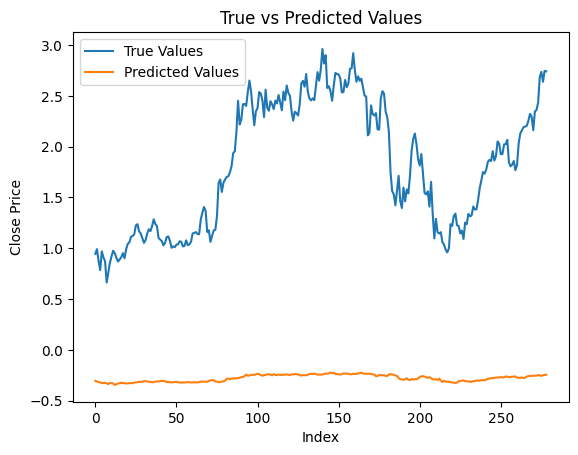

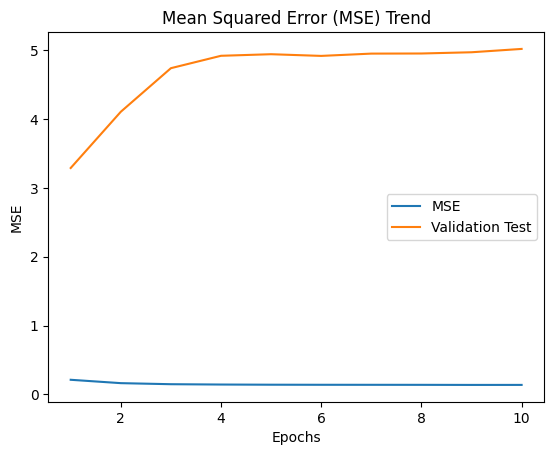

In [ ]:
splitlimit = int(len(amazon_df) * 0.8)
amazon_df_train_set = amazon_df.loc[:splitlimit,:]
amazon_df_test_set = amazon_df.loc[splitlimit:,:]

X_train=[]
y_train =[]
df_days=amazon_df_train_set.shape[0]

for x in range(5, df_days): #prendo intanto una finestra di 5 settimane
  X_train.append(amazon_df.loc[x-5:x-1,'Close'])
  y_train.append(amazon_df.loc[x,'Close'])

X_train,y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))


X_test=[]
y_test =[]

for x in range(df_days, amazon_df.shape[0]): #prendo intanto una finestra di 5 settimane
  X_test.append(amazon_df.loc[x-5:x-1,'Close'])
  y_test.append(amazon_df.loc[x,'Close'])

X_test,y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))

#definition
model=LSTM_model(X_train)
model.build()
display(model.summary())
model.compile(optimizer='adam',
              loss='mean_squared_error')

#training
history = model.fit(X_train, y_train,epochs=10, batch_size=30,validation_data= (X_test,y_test))
y_pred = model.predict(X_test)

# Plot the predicted values
plt.plot(y_test, label='True Values')
plt.plot(y_pred[:,0],  label='Predicted Values')

plt.title('True vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Extract the MSE values from the history object
mse_values = history.history['loss']
validation_values = history.history['val_loss']

# Plot the trend of MSE with respect to epochs
plt.plot(range(1, len(mse_values) + 1), mse_values, label='MSE')
plt.plot(range(1, len(validation_values) + 1), validation_values, label='Validation Test')
plt.title('Mean Squared Error (MSE) Trend')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 5, 50)             10400     
                                                                 
 dropout_2 (Dropout)         (None, 5, 50)             0         
                                                                 
 lstm_3 (LSTM)               (None, 5, 50)             20200     
                                                                 
 dropout_3 (Dropout)         (None, 5, 50)             0         
                                                                 
 dense_1 (Dense)             (None, 5, 1)              51        
                                                                 
Total params: 30651 (119.73 KB)
Trainable params: 30651 (119.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

Epoch 1/10
42/42 [==============================] - 9s 75ms/step - loss: 0.6213 - val_loss: 4.9426
Epoch 2/10
42/42 [==============================] - 2s 36ms/step - loss: 0.6134 - val_loss: 4.6201
Epoch 3/10
42/42 [==============================] - 1s 24ms/step - loss: 0.6095 - val_loss: 4.7761
Epoch 4/10
42/42 [==============================] - 1s 18ms/step - loss: 0.6099 - val_loss: 4.5691
Epoch 5/10
42/42 [==============================] - 1s 22ms/step - loss: 0.6093 - val_loss: 4.7291
Epoch 6/10
42/42 [==============================] - 1s 22ms/step - loss: 0.6080 - val_loss: 4.6064
Epoch 7/10
42/42 [==============================] - 0s 9ms/step - loss: 0.6073 - val_loss: 4.6767
Epoch 8/10
42/42 [==============================] - 0s 10ms/step - loss: 0.6074 - val_loss: 4.7948
Epoch 9/10
42/42 [==============================] - 0s 9ms/step - loss: 0.6072 - val_loss: 4.7981
Epoch 10/10
5/5 [==============================] - 1s 4ms/step


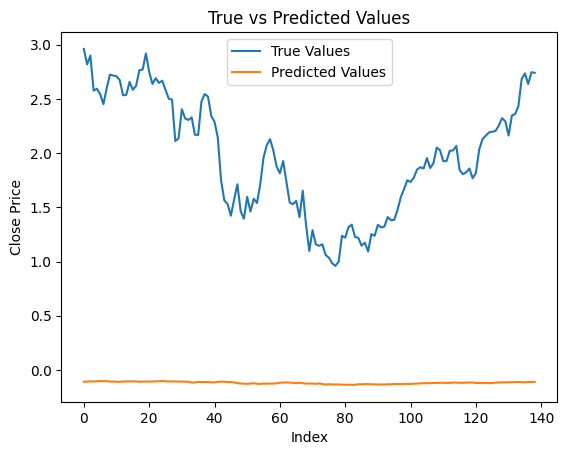

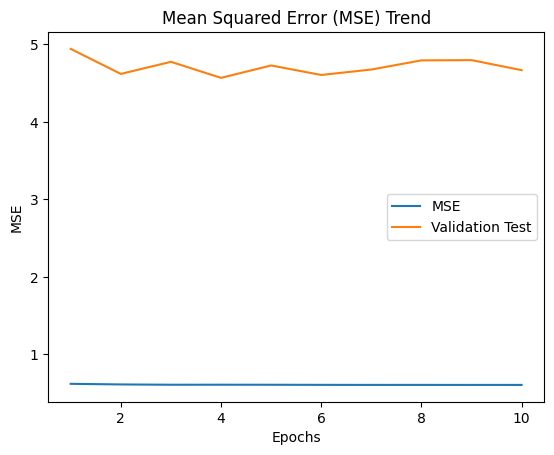

In [ ]:
#SAME MODEL BUT WITH 0.9 AS VALIDATION SET

splitlimit = int(len(amazon_df) * 0.9)
amazon_df_train_set = amazon_df.loc[:splitlimit,:]
amazon_df_test_set = amazon_df.loc[splitlimit:,:]

X_train=[]
y_train =[]
df_days=amazon_df_train_set.shape[0]

for x in range(5, df_days): #prendo intanto una finestra di 5 settimane
  X_train.append(amazon_df.loc[x-5:x-1,'Close'])
  y_train.append(amazon_df.loc[x,'Close'])

X_train,y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))


X_test=[]
y_test =[]

for x in range(df_days, amazon_df.shape[0]): #prendo intanto una finestra di 5 settimane
  X_test.append(amazon_df.loc[x-5:x-1,'Close'])
  y_test.append(amazon_df.loc[x,'Close'])

X_test,y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))

#definition
model=LSTM_model(X_train)
model.build()
display(model.summary())
model.compile(optimizer='adam',
              loss='mean_squared_error')

#training
history = model.fit(X_train, y_train,epochs=10, batch_size=30,validation_data= (X_test,y_test))
y_pred = model.predict(X_test)

# Plot the predicted values
plt.plot(y_test, label='True Values')
plt.plot(y_pred[:,0],  label='Predicted Values')

plt.title('True vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Extract the MSE values from the history object
mse_values = history.history['loss']
validation_values = history.history['val_loss']

# Plot the trend of MSE with respect to epochs
plt.plot(range(1, len(mse_values) + 1), mse_values, label='MSE')
plt.plot(range(1, len(validation_values) + 1), validation_values, label='Validation Test')
plt.title('Mean Squared Error (MSE) Trend')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()